In [107]:
import urllib.request
import gzip
import io
import json
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Step 0: Import data into useable type

# Labels make column-grabbing a lot easier
labels = ['id', 'gender', 'age', 'hypertension', 'heart_disease', 
          'ever_married', 'work_type', 'residence_type', 'avg_glucose_level', 
          'bmi', 'smoking_status', 'stroke']

dataset = pd.read_csv('healthcare-dataset-stroke-data.csv', names=labels)

# Clean null values from data
dataset = dataset.dropna()

dataset = dataset.iloc[1:]
dataset = dataset.drop(columns='id')
dataset.dtypes # Column dtypes should be 'object' for cleaning to work

# Label Encoding allows us to assigns numbers to non-numerical columns categorically
dataset["gender"] = dataset["gender"].astype('category')
dataset["ever_married"] = dataset["ever_married"].astype('category')
dataset["work_type"] = dataset["work_type"].astype('category')
dataset["residence_type"] = dataset["residence_type"].astype('category')
dataset["smoking_status"] = dataset["smoking_status"].astype("category")

dataset["gender"] = dataset["gender"].cat.codes
dataset["ever_married"] = dataset["ever_married"].cat.codes
dataset["work_type"] = dataset["work_type"].cat.codes
dataset["residence_type"] = dataset["residence_type"].cat.codes
dataset["smoking_status"] = dataset["smoking_status"].cat.codes

dataset.head()
# Now data is clean and numerical, all that is left to do is select data
# to nomalize and use in training and testing.

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,1,67,0,1,1,2,1,228.69,36.6,1,1
3,1,80,0,1,1,2,0,105.92,32.5,2,1
4,0,49,0,0,1,2,1,171.23,34.4,3,1
5,0,79,1,0,1,3,0,174.12,24,2,1
6,1,81,0,0,1,2,1,186.21,29,1,1


In [108]:
x = dataset.iloc[:, :-1].values
stroke = dataset.iloc[:, 10].values

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Split data
x_train, x_test, y_train, y_test = train_test_split(x, stroke, test_size=0.25)

# Normalize data
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# Classify with 3-nearest neighbors for KNN
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(x_train, y_train)
# Predict
y_pred = classifier.predict(x_test)

In [110]:
# Analyze with confusion matrix & a report on the classification
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1164   12]
 [  50    2]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1176
           1       0.14      0.04      0.06        52

    accuracy                           0.95      1228
   macro avg       0.55      0.51      0.52      1228
weighted avg       0.92      0.95      0.94      1228



In [120]:
from sklearn.decomposition import PCA

# Compress from 10 components in the dataframe to 2
# We use 2 components so it can be easy to plot
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=3)
principal_components = pca.fit_transform(x)
pca_df = pd.DataFrame(data = principal_components,
                     columns = ['pc1', 'pc2', 'pc3'])

class_df = pd.DataFrame(stroke, columns=['class'])
final_dataframe = pd.concat([pca_df, class_df[['class']]], axis = 1)
final_dataframe

,pc1,pc2,pc3,class
0,2.488343,3.766391,-1.202010,1
1,2.253259,2.464556,0.670414,1
2,1.533631,-0.559837,-0.890100,1
3,1.925290,1.591865,1.009200,1
4,1.422467,1.183818,-0.988225,1
...,...,...,...,...
4904,-2.946101,0.529339,1.002253,0
4905,1.657340,-0.423320,-0.905961,0
4906,-0.052899,-0.773719,1.039413,0
4907,0.468610,1.029739,0.993655,0


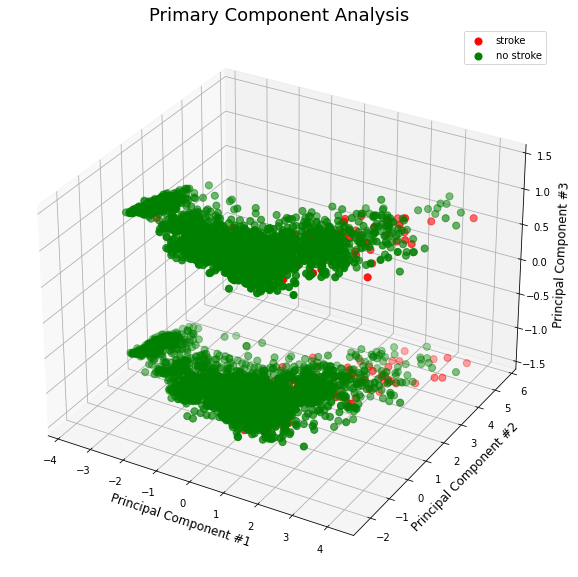

In [121]:
# Visualize PCA as it is the most interesting way to view results
pca_figure = plt.figure(figsize=(10, 10))
axis = plt.axes(projection='3d')
axis.set_title('Primary Component Analysis', fontsize=18)
axis.set_xlabel('Principal Component #1', fontsize=12)
axis.set_ylabel('Principal Component #2', fontsize=12)
axis.set_zlabel('Principal Component #3', fontsize=12)

legend1 = ['stroke', 'no stroke']
classes = ['1', '0']
colors = ['red', 'green', 'blue']

for x_match, color in zip(classes, colors):
    match = final_dataframe['class'] == x_match
    axis.scatter(final_dataframe.loc[match, 'pc1']
              , final_dataframe.loc[match, 'pc2']
              , final_dataframe.loc[match, 'pc3']
              , c = color
              , s = 50)
axis.legend(legend1)
axis.grid()